The goal is to build a CNN model to review variants (SNVs and small INDELs) called by somatic pipeline implemented at BCGSC.

Currently, let's focus on only SNVs since it is probably the easiest task and them move on to INDELs if it works.

This work is inspired by and references deepvariant.

In [1]:
import pysam
import pandas as pd
import seaborn as sns
from matplotlib import style, colors
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### some relevant samtools commands

this command give you the reference sequence

samtools faidx /projects/rcorbettprj2/GATK4VariantCall/GRCh37-lite.fa 1:10000-10020

In [12]:
# extract reads in a region and sort based on alignment position
# samtools view -h -q 10 /projects/analysis/analysis22/A37234/merge_bwa-mem-0.7.6a/125nt/hg19a/A37234_4_lanes_dupsFlagged.bam 5:1295228-1295229 | awk 'BEGIN{OFS="\t"}{if($1 ~ /^"@"/) {print} else {if($4 >= 1295220 || $4 <=1295230) {print} else {}}}'|sort -k4n|samtools view -Sbo /projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/test.bam -

### paysam 0 indexed, bam in 1 indexed

In [12]:
# ref = '/home/pubseq/genomes/Homo_sapiens/hg19a/bwa_ind/genome/GRCh37-lite.fa' # depreciated
ref = '/projects/alignment_references/Homo_sapiens/hg19a/genome/fasta/hg19a.fa'
bam = '/projects/analysis/analysis22/A37234/merge_bwa-mem-0.7.6a/125nt/hg19a/A37234_4_lanes_dupsFlagged.bam'
# test bam only have 60 reads
# bam = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/test.bam'

In [3]:
def get_ref_seqs(ref_file, region):
    return ''.join(pysam.faidx(ref, region).split('\n')[1:])

In [4]:
# confirmed ref sequence in UCSC genome browser
assert get_ref_seqs(ref, '1:10000-10003') == 'NTAA'
assert get_ref_seqs(ref, '3:178928000-178928020') == 'TATAAACTTGTTTGATTACAC'
get_ref_seqs(ref, '3:1295226-1295227')
get_ref_seqs(ref, '1:1239339-1239339')

'AT'

'T'

In [5]:
def extract_reads(bam, chrm, start, flank_length):
    samfile = pysam.AlignmentFile(bam, 'rb')
    df = pd.DataFrame()
    for pileupcolumn in samfile.pileup(str(chrm), start, start+1, truncate=False):# min_base_quality=0
        for pileupread in pileupcolumn.pileups:
            if not pileupread.is_del and not pileupread.is_refskip:
                read_name = pileupread.alignment.query_name
                align_pos = pileupcolumn.pos    
                base = pileupread.alignment.query_sequence[pileupread.query_position]
                df.loc[read_name, align_pos+1] = base # something to do with 0 or 1 based indexing
    samfile.close()
#     sometime reads does not spread to cover entire window
    df = df.reindex(columns=range(start-flank_length, start+flank_length+1))
#     df = df.loc[:, start-flank_length:start+flank_length]
#     print(f'extract reads df {df.shape}',start-flank_length, start+flank_length, df)
    return df

In [6]:
def pileup_matrix(ref, df, chrm, start, flank_length):
    mapdict = {'A':1, 'T':2, 'C':3, 'G':4, 'read_end':5}
    col_start = start-flank_length
    col_end = start+flank_length
    # add reference sequence
    # pysam is 0 indexed, i think the ref is 1 indexed?
    query = ''.join([str(chrm), ':', str(col_start), '-', str(col_end)])
    refseq = get_ref_seqs(ref, query)
    anchor = ['read_end'] * len(refseq)
    anchor[flank_length] = refseq[flank_length]
#     print(f'anchor length is {len(anchor)}, df dimension is {df.shape}')
    df.loc['anchor', :] = list(anchor)
    df.loc['refseq', :] = list(refseq)
    rows = df.index.tolist()
    rows = rows[-2:] + rows[:-2] 
    nrows, ncols = df.shape
    if nrows < ncols:
        padding = range(ncols - nrows) # offset the reference row to maintain square shape
        padding_idx = [''.join(['padding_', str(i)]) for i in padding]
        rows = list(rows) + padding_idx
        df = df.reindex(rows)
    else: 
        df = df.iloc[:nrows-2, :]
    df.fillna('read_end', inplace=True) 
    df = df.apply(lambda x: x.map(mapdict))
    return df


In [7]:
def make_cmap_for_heatmap(categories, color_dict):
    '''map category types to a number and make a cmap for heatmap'''
    map_dict = {k:v for v, k in  enumerate(categories)} 
    clrs = [color_dict[m] for m in categories]
    cmap = colors.ListedColormap(clrs)
#     print('colors used:')
#     for cat, c in zip(categories, clrs):
#         print(cat, c)
#     sns.palplot(clrs)
    return (map_dict, cmap)

In [176]:
def plot_old(df, path, patient, chrm, pos):
    color_dict = {'A':'green', 'T':'red', 'C':'blue', 'G':'orange', 'read_end':'white'}
    cats = ['A', 'T', 'C', 'G', 'read_end']
    dpi = 1
    pixel_loss = 0.755
    nr, nc = df.shape
    _, clrmap = make_cmap_for_heatmap(cats, color_dict)
    f, ax = plt.subplots(figsize=(nc/dpi/pixel_loss,nc/dpi/pixel_loss), dpi=dpi)
    _ = sns.heatmap(df, ax=ax, cmap=clrmap, cbar=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    of = '.'.join([patient, chrm, pos, 'png'])
    of = ''.join([path, of])
    _ = plt.savefig(of, dpi=dpi, bbox_inches='tight')
    plt.close()

In [8]:
def plot(df, path, patient, chrm, pos):
    color_dict = {'A':'green', 'T':'red', 'C':'blue', 'G':'orange', 'read_end':'white'}
    cats = ['A', 'T', 'C', 'G', 'read_end']
    dpi = 1
    pixel_loss = 0.755
    nr, nc = df.shape
    _, clrmap = make_cmap_for_heatmap(cats, color_dict)
    f, ax = plt.subplots(figsize=(nc/dpi/pixel_loss,nc/dpi/pixel_loss), dpi=dpi)
    _ = ax.imshow(df, interpolation='nearest', cmap=clrmap)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    of = '.'.join([patient, chrm, pos, 'png'])
    of = ''.join([path, of])
    _ = plt.savefig(of, dpi=dpi, bbox_inches='tight')
    plt.close()

In [11]:
bam

'/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/test.bam'

In [13]:
read_length = 148
flank_length = read_length -2
path = '/projects/da_workspace/szspace/data/giab/image2/'
patient = 'giab'
dfa = extract_reads(bam, 1, 1239339, flank_length)
dfa.head()
print(dfa.shape)
dfb = pileup_matrix(ref, dfa,1, 1239339, flank_length)
_ = plot(dfb, path, patient, '1', '1239339')


,1239193,1239194,1239195,1239196,1239197,1239198,1239199,1239200,1239201,1239202,...,1239476,1239477,1239478,1239479,1239480,1239481,1239482,1239483,1239484,1239485
HS20_129:1:1112:4544:28082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HS16_125:1:2111:14731:44618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HS16_125:1:2304:11716:68135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HS20_129:1:2115:7567:32654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HS18_44:1:1205:9249:73453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(68, 293)


### generate training examples for GIAB project

In [208]:
# of = '/projects/da_workspace/szspace/data/giab/ground_truth_calls.txt'
# df = pd.read_csv(of, sep='\t')
# df.head(2)

why there are na values at some position

## generate positive images

In [14]:
f = '/projects/da_workspace/szspace/data/giab/ground_truth_calls_platform_illumina.txt'
df = pd.read_csv(f, sep=' ', low_memory=False)
df.shape
df.head()

(3257176, 7)

,chr,pos,ref,alt,Illumina,dataset,genotype
0,1,239339,A,G,Illumina,10XChromium,0/1
1,1,239482,G,T,Illumina,HiSeqPE300x,0/1
2,1,240147,C,T,Illumina,HiSeqPE300x,0/1
3,1,240898,T,G,Illumina,HiSeqPE300x,0/1
4,1,837214,G,C,Illumina,SolidSE75bp,0|1


In [15]:
df['chr'] = df['chr'].astype(str)
d = {'0/1':1, '0|1':2, '1|1':3, '1|0':4}
df['target'] = df.genotype.map(d)

In [16]:
dfsub = df.sample(n=2000, weights='target', random_state=1).reset_index(drop=True)
dfsub.sort_values(['chr', 'pos'], inplace=True)

In [17]:
dfsub.head(2)

,chr,pos,ref,alt,Illumina,dataset,genotype,target
2,1,1239339,T,G,Illumina,SolidSE75bp,1|1,3
250,1,2288747,T,C,Illumina,10XChromium,1|0,4


In [21]:
bam = '/projects/da_workspace/szspace/data/giab/RMNISTHS_30xdownsample.bam'

read_length = 148
flank_length = read_length -2 # 2 base overhang

patient = 'giab'
path = '/projects/da_workspace/szspace/data/giab/image2/'

for ix, row in dfsub.iterrows():
    chrm = row['chr']
    pos = row['pos']
    print(f'processing {chrm}:{pos}')
    df1 = extract_reads(bam, chrm, pos, flank_length)
    df1 = pileup_matrix(ref, df1, chrm, pos, flank_length)    
    _ = plot(df1, path, patient, str(chrm), str(pos))

processing 1:1239339
processing 1:2288747
processing 1:3325330
processing 1:4129247
processing 1:8856972
processing 1:9177317
processing 1:9364634
processing 1:10957719
processing 1:11683792
processing 1:16651580
processing 1:17373205
processing 1:18448811
processing 1:22529868
processing 1:24234958
processing 1:25439449
processing 1:28283443
processing 1:30031249
processing 1:30986389
processing 1:31711409
processing 1:32057186
processing 1:33445837
processing 1:34038850
processing 1:36729736
processing 1:38424424
processing 1:39647696
processing 1:40007829
processing 1:41770055
processing 1:42327671
processing 1:43812075
processing 1:44455203
processing 1:44996464
processing 1:46389217
processing 1:47472464
processing 1:47672289
processing 1:48421694
processing 1:49524639
processing 1:49721079
processing 1:50191057
processing 1:52452481
processing 1:55066759
processing 1:55400926
processing 1:59100436
processing 1:59201197
processing 1:59940664
processing 1:60086793
processing 1:6247

processing 11:123381605
processing 11:124725460
processing 11:125512619
processing 11:125630984
processing 11:125632820
processing 11:126911042
processing 11:128629871
processing 11:129181186
processing 11:130909397
processing 11:130987535
processing 11:131979769
processing 12:4118317
processing 12:5560017
processing 12:5764916
processing 12:6525518
processing 12:7524910
processing 12:12238083
processing 12:12699515
processing 12:13449850
processing 12:14507419
processing 12:15391157
processing 12:16253276
processing 12:16600256
processing 12:17179401
processing 12:17951119
processing 12:18515117
processing 12:19705240
processing 12:19913591
processing 12:21374538
processing 12:21528337
processing 12:22540827
processing 12:24768847
processing 12:24908928
processing 12:25460551
processing 12:26475553
processing 12:29662568
processing 12:29856524
processing 12:30411798
processing 12:30590426
processing 12:32208732
processing 12:34441574
processing 12:40020756
processing 12:40141182
proce

processing 17:4338964
processing 17:9750751
processing 17:10061464
processing 17:11868362
processing 17:12219180
processing 17:12504462
processing 17:12964206
processing 17:13852264
processing 17:14520034
processing 17:17073576
processing 17:21779194
processing 17:27178761
processing 17:29888092
processing 17:32466711
processing 17:32803030
processing 17:33121099
processing 17:34442472
processing 17:34836727
processing 17:34985674
processing 17:35261346
processing 17:36539177
processing 17:39098034
processing 17:41713707
processing 17:44873076
processing 17:45930822
processing 17:46438131
processing 17:47768245
processing 17:48905408
processing 17:49022950
processing 17:49675973
processing 17:50552051
processing 17:51100733
processing 17:51887591
processing 17:54873611
processing 17:58831807
processing 17:61207365
processing 17:63681066
processing 17:65620862
processing 17:69678503
processing 17:69960575
processing 17:70448287
processing 17:70703071
processing 17:71210925
processing 17

processing 21:21388151
processing 21:21480848
processing 21:22560908
processing 21:22896160
processing 21:23409240
processing 21:23935212
processing 21:24549547
processing 21:24729289
processing 21:25237497
processing 21:25766411
processing 21:26108951
processing 21:26670455
processing 21:27273508
processing 21:28048824
processing 21:28106677
processing 21:28778338
processing 21:30442481
processing 21:31899451
processing 21:32058224
processing 21:33700007
processing 21:34366973
processing 21:35871379
processing 21:38800108
processing 21:40029090
processing 21:42074376
processing 21:42410744
processing 21:44263041
processing 21:46529198
processing 21:47577483
processing 22:19677839
processing 22:22394749
processing 22:22462358
processing 22:26380389
processing 22:30054024
processing 22:35063674
processing 22:35606111
processing 22:36887140
processing 22:36890520
processing 22:37217879
processing 22:37558356
processing 22:39414904
processing 22:39755441
processing 22:43070623
processing 

processing 5:42907385
processing 5:43610401
processing 5:46353859
processing 5:51919136
processing 5:53502751
processing 5:53916356
processing 5:54535123
processing 5:57467546
processing 5:57770177
processing 5:57838577
processing 5:59843846
processing 5:60339606
processing 5:62509225
processing 5:64857063
processing 5:65079411
processing 5:67294907
processing 5:70854517
processing 5:71046366
processing 5:71837459
processing 5:72126362
processing 5:72488283
processing 5:77588467
processing 5:82422087
processing 5:84545425
processing 5:84811033
processing 5:85431168
processing 5:89641900
processing 5:94000264
processing 5:100104662
processing 5:100898218
processing 5:101763870
processing 5:102163781
processing 5:105299490
processing 5:107407291
processing 5:110032566
processing 5:111016028
processing 5:111040322
processing 5:111687945
processing 5:112378393
processing 5:113068433
processing 5:115306037
processing 5:116075842
processing 5:116439784
processing 5:117323263
processing 5:117

processing 8:101058597
processing 8:101768675
processing 8:102315189
processing 8:103660496
processing 8:104196713
processing 8:104222329
processing 8:104387531
processing 8:105069114
processing 8:107967119
processing 8:113283680
processing 8:115725090
processing 8:117215856
processing 8:118415550
processing 8:119350592
processing 8:120670531
processing 8:123449953
processing 8:123590010
processing 8:123896124
processing 8:125771199
processing 8:126863650
processing 8:127195818
processing 8:127582474
processing 8:128514398
processing 8:128520173
processing 8:128775503
processing 8:129119667
processing 8:129212443
processing 8:129545928
processing 8:131022470
processing 8:133512310
processing 8:135939600
processing 8:137344673
processing 8:139086291
processing 8:141175902
processing 8:142536657
processing 8:142543137
processing 8:142619393
processing 8:144799465
processing 8:145259406
processing 9:671053
processing 9:1316789
processing 9:1574690
processing 9:1578529
processing 9:2697549

# generate negative images

In [22]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/notebook/random_positions.txt'
df2 = pd.read_csv(f, sep='\t', header=None)
df2.columns = ['chr', 'pos']
df2.shape
df2.head(2)

(2000, 2)

,chr,pos
0,5,33654973
1,12,20645578


In [23]:
bam = '/projects/da_workspace/szspace/data/giab/RMNISTHS_30xdownsample.bam'
read_length = 148
flank_length = read_length -2 # 5 base overhang
patient = 'giab'
path = '/projects/da_workspace/szspace/data/giab/image2/'

for ix, row in df2.iterrows():
    chrm = row['chr']
    pos = row['pos']
    print(f'{chrm}:{pos}')
    df1 = extract_reads(bam, chrm, pos, flank_length)
    df1 = pileup_matrix(ref, df1, chrm, pos, flank_length)    
    _ = plot(df1, path, patient, str(chrm), str(pos))

5:33654973
12:20645578
14:66189388
X:123437045
6:49025787
2:210980552
2:128326152
1:222610770
6:164293711
7:7503246
12:38728177
10:4220748
3:101778305
7:18260686
17:62730677
3:98006933
X:8443434
17:44155078
10:131769787
7:92008474
16:44029380
19:58075555
15:55950256
2:194401958
3:98856714
1:217918458
11:51552174
4:79307047
17:28800308
12:53474238
12:13609930
15:77307762
17:46673468
Y:2722526
6:35863991
18:25842372
10:54821618
8:115633032
2:54016790
5:155903928
3:174273516
13:43916104
X:144932929
12:11771219
8:89796794
11:42208482
3:100898970
17:21458617
X:32716619
2:15857964
3:174863778
12:39382543
12:53796494
2:30092526
4:154745502
2:155790708
14:63160889
2:27921553
3:53084749
5:179964827
7:60848136
6:154044939
13:33511750
17:71138073
1:212984425
9:36174097
13:14184248
5:94050372
6:100600310
10:84950526
14:33969311
8:50379909
13:30195861
2:11977477
17:26010989
6:16962150
7:133022870
1:92458564
8:136104029
17:65778387
4:87749755
17:58400554
7:7003055
2:165791858
7:84911653
14:1849424
3

4:188406822
6:107208552
14:71728416
5:76824953
17:74734103
2:109500314
X:144141658
6:141310720
8:58861288
14:105459707
16:77161588
5:131548520
7:52855144
3:175796784
Y:39941911
15:5984617
9:78088297
6:49830386
9:10892526
4:17799886
1:70687731
2:104426424
12:99339577
11:131092130
3:159422595
14:56186327
5:145625238
7:121813732
7:58282090
9:3507240
9:98135788
2:57969740
6:47731858
2:42097742
12:90304895
17:20106272
11:116097353
5:138788065
2:32513123
2:134847491
4:147892881
18:58970264
14:67687833
18:20528991
7:137336398
11:13114199
22:25491067
8:120885754
5:53079781
Y:43634367
15:88498917
6:31183419
8:53619005
7:54737400
18:70625085
4:179431593
7:154912615
14:85585782
12:34222635
2:38896696
4:38960403
6:45279337
1:239326404
9:84329861
12:21499429
9:37729653
9:82098462
2:54944828
5:152571029
1:204428140
4:61176864
5:79935286
5:57650865
13:65418371
2:31407884
6:19445389
18:59184005
21:7228414
20:24116029
14:71209356
6:37673960
11:96384098
8:28008567
9:84146955
3:83419999
5:39547536
12:870

8:125864957
20:72889
7:123411104
18:17239510
10:1419067
12:40504350
8:85262044
4:67418331
15:79931633
14:57130393
13:107935802
12:35259652
8:69227391
5:106412297
X:45419276
22:20565496
6:34117577
1:137503294
16:46068442
X:119134061
2:93769150
7:144817634
15:40274036
X:131081960
13:95569499
4:38787865
6:29987905
5:169696628
X:7872514
X:59052737
6:25911800
14:26263193
8:9209120
17:16118672
2:141211282
1:51898817
11:80953577
16:70282696
3:170667069
1:31234636
2:204186705
4:94493442
1:71587461
3:94422722
2:119890996
4:20178306
1:187282805
20:30701511
4:190298411
17:43360124
17:16450272
18:10894144
7:120818417
16:34937065
1:212231754
3:191388083
2:45801353
20:22311322
2:229982080
14:54832160
1:151949
21:26371085
11:64101538
22:32152622
1:240029580
11:31249414
4:140413712
21:24956201
4:39898033
13:23392108
4:164809678
20:44090323
3:122537960
13:2302619
10:49637854
1:164051922
1:236828077
14:40823809
11:125252569
14:11077234
8:61358414
X:10797933
13:108802120
19:26067246
15:29188923
12:102035

processing 1:239339


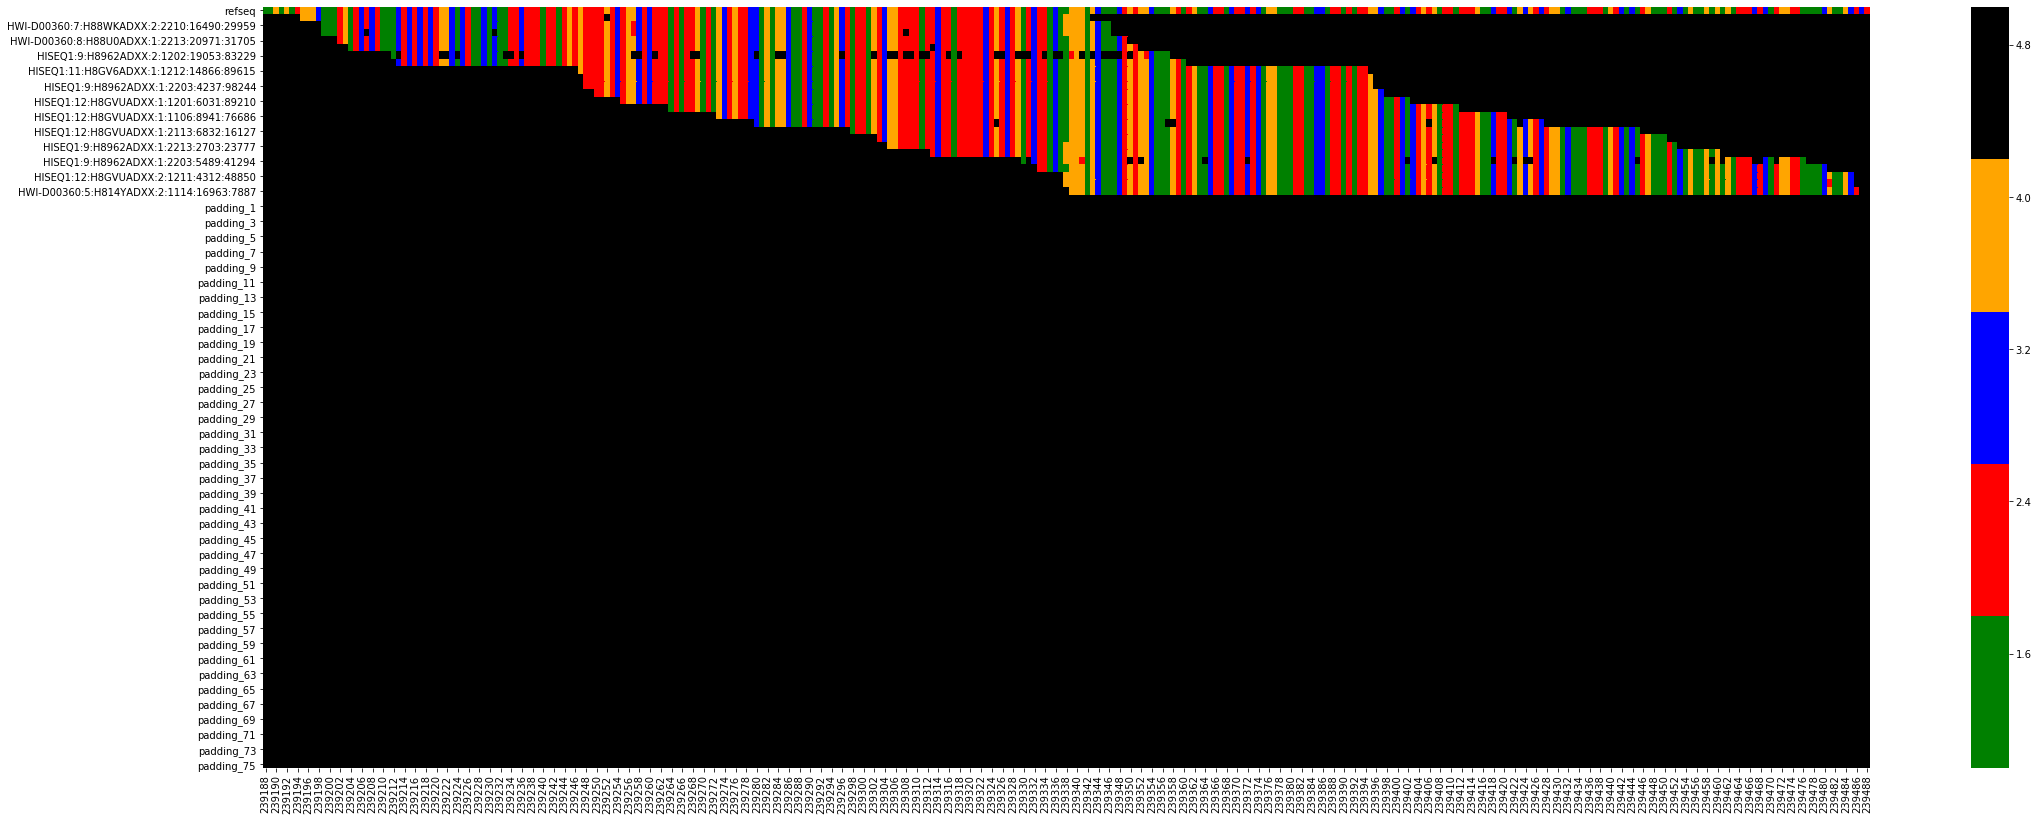

In [46]:
bam = '/projects/da_workspace/szspace/data/giab/RMNISTHS_30xdownsample.bam'
flank_length = 150
for ix, row in df.head(1).iterrows():
    chrm = row['chr']
    start = row['pos']
    print(f'processing {chrm}:{start}')
    df1 = extract_reads(bam, chrm, start)
    df1 = pileup_to_image(df1, chrm, start, flank_length)
    f, ax = plt.subplots(figsize=(0.34,0.34), dpi=10)
#     print(df1)
    plot(df1)
    plt.show()

In [43]:
# df1
df1.shape
df1.columns

(101, 231)

Int64Index([239223, 239224, 239225, 239226, 239227, 239228, 239229, 239230,
            239231, 239232,
            ...
            239444, 239445, 239446, 239447, 239448, 239449, 239450, 239451,
            239452, 239453],
           dtype='int64', length=231)

In [47]:
# df1.loc['HISEQ1:9:H8962ADXX:2:1202:19053:83229',:]

# plot pixels

https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels

figure size and dpi missing pixels, something i don't fully understand

[]

[]

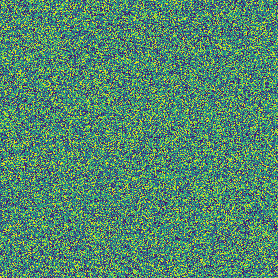

In [174]:
import matplotlib.pyplot as plt
import numpy as np
s = 278
dpi = 1
pixel_loss = 0.755
data = np.random.random(size=(s, s))
f, ax = plt.subplots(figsize=(s/dpi/pixel_loss,s/dpi/pixel_loss), dpi=dpi)
ax.imshow(data, interpolation='nearest')
# plt.xticks(np.arange(0.0, 2.5, 1), np.arange(0.5, 2, 0.5))
# plt.yticks(np.arange(2, -0.5, -1), np.arange(0.5, 2, 0.5))
ax.set_xticklabels([])
ax.set_yticklabels([])
of = '/home/szong/Downloads/xxxx.png'
plt.savefig(of, bbox_inches='tight', dpi=dpi)

In [166]:
data

array([[0.76362424, 0.56767916, 0.91152442, 0.87800946, 0.29960383],
       [0.04506519, 0.33110236, 0.75568593, 0.85757252, 0.32770254],
       [0.79067162, 0.04892749, 0.3337207 , 0.25145369, 0.04068508],
       [0.36238286, 0.59412964, 0.32346599, 0.87528722, 0.42752563],
       [0.44904936, 0.59274456, 0.14373129, 0.17848536, 0.93012704]])